In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#cd '/content/drive/MyDrive/HDA_project'

In [3]:
#!unzip "/content/drive/MyDrive/HDA_project/HDA_proj_A2.zip" -d "/content/Subjects"

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Requirements

In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import copy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import random
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import time
import psutil


In [6]:
#base_dir = '/content/Subjects/'

base_dir = 'content/Subjects/'

data = []

# Traverse the folder structure
for subject_folder in os.listdir(base_dir):
    subject_path = os.path.join(base_dir, subject_folder)
    if os.path.isdir(subject_path):
        for gait_type_folder in os.listdir(subject_path):
            gait_type_path = os.path.join(subject_path, gait_type_folder)
            if os.path.isdir(gait_type_path):
                for trial_folder in os.listdir(gait_type_path):
                    trial_path = os.path.join(gait_type_path, trial_folder)
                    if os.path.isdir(trial_path):
                        skeleton_file = os.path.join(trial_path, 'skeleton.csv')
                        pressure_file = os.path.join(trial_path, 'pressure.csv')

                        if os.path.exists(skeleton_file) and os.path.exists(pressure_file):
                            skeleton_data = pd.read_csv(skeleton_file)
                            pressure_data = pd.read_csv(pressure_file)

                            combined_data = {
                                'Subject': subject_folder,
                                'Gait_type': gait_type_folder,
                                'Trial': trial_folder,
                                'Skeleton_data': skeleton_data.values.tolist(),
                                'Foot_pressure_data': pressure_data.values.tolist(),
                            }
                            data.append(combined_data)

dataset = pd.DataFrame(data)
dataset

,Subject,Gait_type,Trial,Skeleton_data,Foot_pressure_data
0,subject1,antalgic,trial1,"[[20200901_11:51:-09.239, 0.470053, -0.020303,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,subject1,antalgic,trial10,"[[20200901_11:54:-22.007, -0.049837, -0.535304...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,subject1,antalgic,trial11,"[[20200901_11:54:-41.335, -0.013374, -0.527909...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,subject1,antalgic,trial12,"[[20200901_11:54:-59.707, -0.030168, -0.513855...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,subject1,antalgic,trial13,"[[20200901_11:55:-18.015, -0.050954, -0.568145...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...
1435,subject9,trendelenburg,trial5,"[[20201125_02:56:-23.228, -0.311098, 0.857038,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1436,subject9,trendelenburg,trial6,"[[20201125_02:56:-39.600, -0.283077, 0.868874,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1437,subject9,trendelenburg,trial7,"[[20201125_02:56:-55.608, -0.245757, 0.866144,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1438,subject9,trendelenburg,trial8,"[[20201125_02:57:-10.984, -0.364491, 0.49827, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [7]:
foot_pressure_data = dataset['Foot_pressure_data']
skeleton_data = dataset['Skeleton_data']

In [8]:
print(skeleton_data[1][1][0])
print(skeleton_data[2][2][0])

20200901_11:54:-22.051
20200901_11:54:-41.391


In [9]:
# Timestamp data transformation
def parse_timestamp(timestamp_str):
    date_str, time = timestamp_str.split('_')
    hours, minutes, seconds = time.split(':')
    seconds, milliseconds = seconds.split('.')
    seconds = seconds.lstrip('-')

    corrected_timestamp = f"{date_str}_{hours}:{minutes}:{seconds}.{milliseconds}"
    timestamp_format = "%Y%m%d_%H:%M:%S.%f"
    parsed_time = datetime.strptime(corrected_timestamp, timestamp_format)
    total_seconds = parsed_time.hour * 3600 + parsed_time.minute * 60 + parsed_time.second + parsed_time.microsecond / 1_000_000
    return total_seconds

for i in range(len(skeleton_data)):
  for j in range(len(skeleton_data[i])):
    skeleton_data[i][j][0] = parse_timestamp(str(skeleton_data[i][j][0]))
skeleton_data[1][1][0]

42862.051

# Visualization
## Skeleton Data

In [10]:
# The hierarchy defined as a dictionary
hierarchy = {
    0: None,
    1: 0, 2: 1, 3: 2,
    4: 2, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 7,
    11: 2, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 14,
    18: 0, 19: 18, 20: 19, 21: 20,
    22: 0, 23: 22, 24: 23, 25: 24,
    26: 3, 27: 26, 28: 26, 29: 26, 30: 26, 31: 26
}

connections = [(child, parent) for child, parent in hierarchy.items() if parent is not None]

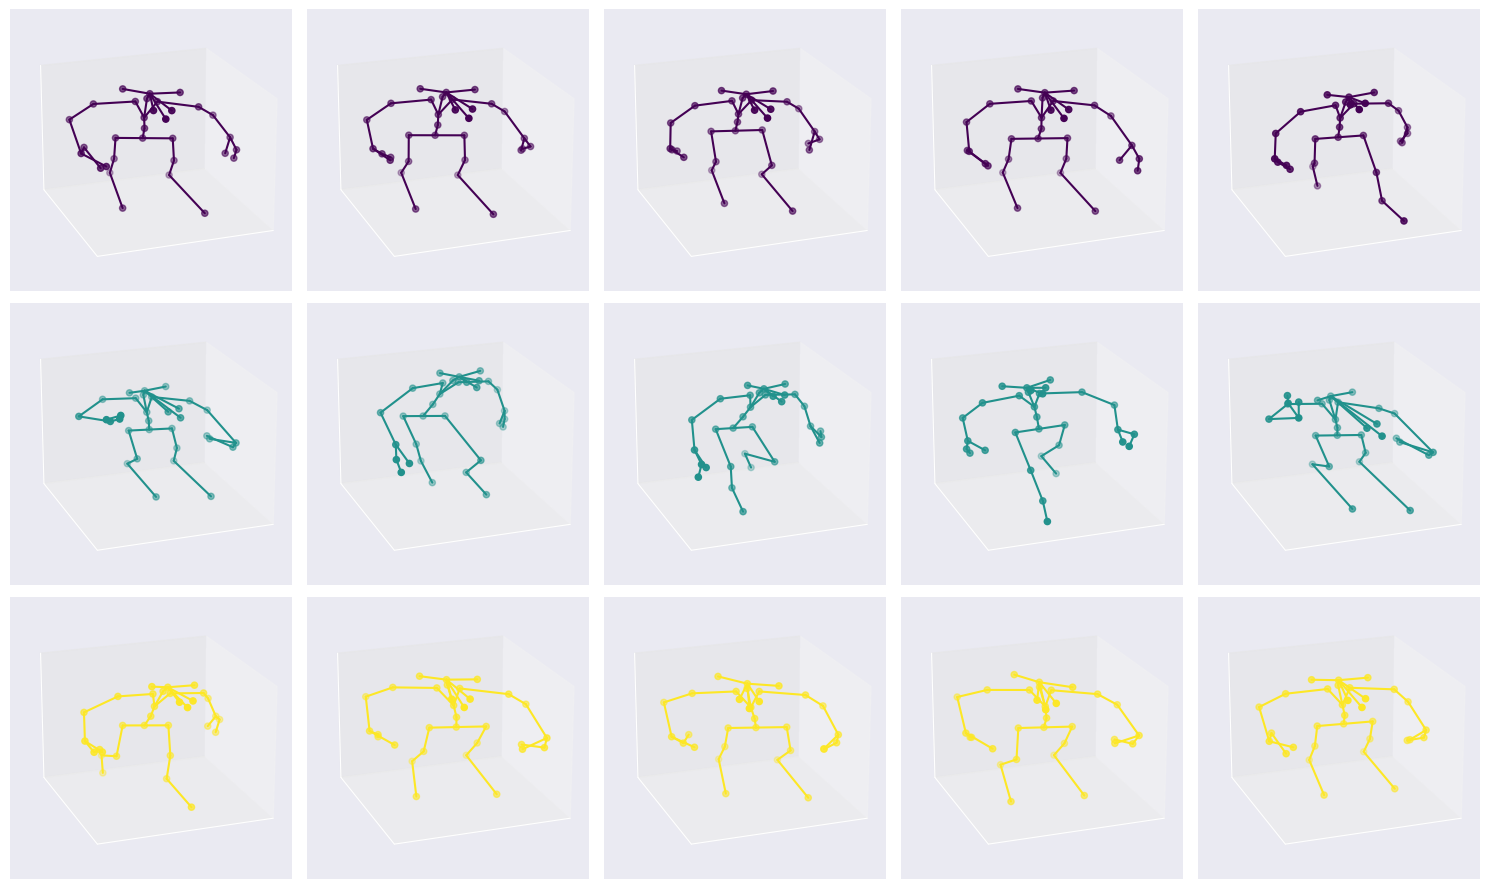

In [11]:
def visualize_multiple_skeletons(skeleton_data, connections):
    """
    Visualizes skeletons from different trials in a 3x5 grid.

    skeleton_data: The dataset containing skeleton sequences
    connections: List of tuples defining joint connections
    """
    num_trials = 3
    frames_per_trial = 5

    fig, axes = plt.subplots(num_trials, frames_per_trial, figsize=(15, 9), subplot_kw={'projection': '3d'})
    colormap = cm.get_cmap("viridis", num_trials)
    colors = [colormap(i) for i in range(num_trials)]
    for row in range(num_trials):
        trial_idx = random.randint(0, len(skeleton_data) - 1)
        color = colors[row]

        for col in range(frames_per_trial):
            frame_idx = random.randint(0, len(skeleton_data[trial_idx]) - 1)
            skeleton_frame = np.array(skeleton_data[trial_idx][frame_idx][1:-1]).reshape(32, 3)

            ax = axes[row, col]
            ax.scatter(skeleton_frame[:, 0], skeleton_frame[:, 1], skeleton_frame[:, 2], color=color, label=f"Trial {row+1}")

            for child, parent in connections:
                ax.plot(
                    [skeleton_frame[child, 0], skeleton_frame[parent, 0]],
                    [skeleton_frame[child, 1], skeleton_frame[parent, 1]],
                    [skeleton_frame[child, 2], skeleton_frame[parent, 2]],
                    color=color
                )

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            ax.view_init(elev=20, azim=70)

    plt.tight_layout()
    plt.show()

visualize_multiple_skeletons(skeleton_data, connections)


## Foot Pressure Data

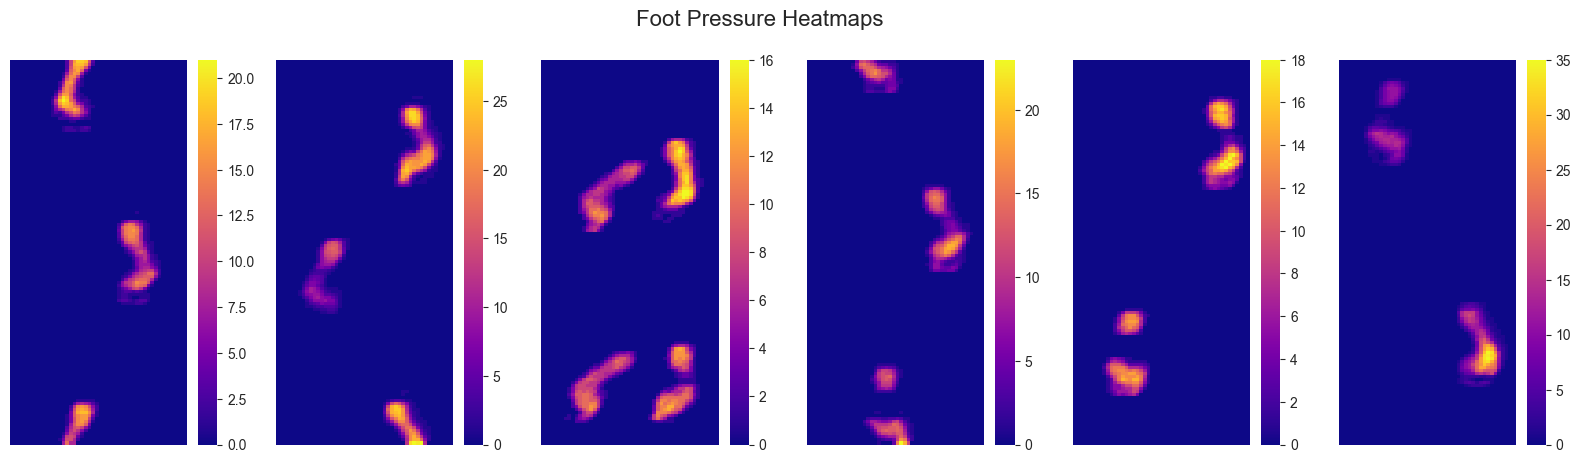

In [12]:
random_indices = np.random.choice(1400, 6, replace=False)
selected_samples = [foot_pressure_data[i] for i in random_indices]

# Heatmaps
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

for idx, ax in enumerate(axes):
    sns.heatmap(selected_samples[idx], cmap='plasma', ax=ax, cbar=True)
    ax.axis("off")

plt.suptitle("Foot Pressure Heatmaps", fontsize=16)
plt.show()

## Manual Feature Extraction

In [13]:
# Joint velocities computation
def calculate_joint_velocities_optimized(skeleton_data_trim):
    velocities = []

    for subject in skeleton_data_trim:
        timestamps = np.array([frame[0] for frame in subject], dtype=np.float64)
        joint_positions = np.array([frame[1:-1] for frame in subject])

        time_deltas = np.diff(timestamps)
        time_deltas[time_deltas == 0] = np.nan

        position_deltas = np.diff(joint_positions, axis=0)
        reshaped_deltas = position_deltas.reshape(-1, 32, 3)
        distances = np.linalg.norm(reshaped_deltas, axis=2)
        velocities_subject = distances / time_deltas[:, None]

        velocities_subject = np.vstack(([np.nan] * 32, velocities_subject))
        velocities.append(velocities_subject)

    return velocities


In [14]:
computed_velocities = calculate_joint_velocities_optimized(skeleton_data)
computed_velocities = [np.where(np.isnan(sublist), 0, sublist) for sublist in computed_velocities]

In [15]:
# One-hot-encoding of class labels
gait_labels = dataset['Gait_type']
gait_labels_encoded = pd.factorize(gait_labels)[0]
num_classes = len(gait_labels.unique())
gait_labels_one_hot = to_categorical(gait_labels_encoded, num_classes=num_classes)
gait_labels_one_hot

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

## Data Pre-Processing

In [16]:
# Normalization functions
def normalize_skeleton_data(skeleton_data):
    normalized_data = []

    for trial in skeleton_data:
        trial_data = np.array([frame[1:-1] for frame in trial])  # Removing timestamp and NaN value at the end
        reshaped_trial = trial_data.reshape(-1, 32, 3)
        mean = np.mean(reshaped_trial, axis=0)
        std = np.std(reshaped_trial, axis=0)
        normalized_trial = (reshaped_trial - mean) / std
        normalized_trial = normalized_trial.reshape(-1, 32 * 3)
        normalized_data.append(normalized_trial)
    return normalized_data

def normalize_joint_velocities(joint_velocities):
    normalized_data = []

    for trial in joint_velocities:
        trial_data = np.array(trial)
        mean = np.mean(trial_data, axis=0)
        std = np.std(trial_data, axis=0)
        std[std == 0] = 1e-8  # To prevent dividing by zero, if std is zero
        normalized_trial = (trial_data - mean) / std
        normalized_data.append(normalized_trial)
    return normalized_data

def normalize_pressure_data(pressure_data):
    normalized_data = []

    for trial in pressure_data:
        normalized_trial = []
        for timestep in trial:
            timestep_data = np.array(timestep)
            min_val = np.min(timestep_data)
            max_val = np.max(timestep_data)

            if max_val - min_val == 0: # To prevent dividing by zero
                normalized_timestep = np.zeros_like(timestep_data)
            else:
                normalized_timestep = (timestep_data - min_val) / (max_val - min_val)
            normalized_trial.append(normalized_timestep)
        normalized_data.append(normalized_trial)
    return normalized_data

In [17]:
# Data Normalization
skeleton_data_norm = normalize_skeleton_data(skeleton_data)
joint_velocities_norm = normalize_joint_velocities(computed_velocities)
pressure_data_norm = normalize_pressure_data(foot_pressure_data)

In [18]:
# Trimming
skeleton_data_trim = [
    [[timestamp[i] for i in range(75)] for timestamp in trial]
    for trial in skeleton_data_norm
]

joint_velocities_trim = [
    [[timestamp[i] for i in range(25)] for timestamp in trial]
    for trial in joint_velocities_norm
]

In [19]:
# Padding
skeelton_data_padded = pad_sequences(skeleton_data_trim, padding='post', dtype='float32')
joint_velocities_padded = pad_sequences(joint_velocities_trim, padding='post', dtype='float32')
pressure_data_padded = pad_sequences(pressure_data_norm, padding='post', dtype='float32')

print(skeelton_data_padded[0].shape)
print(joint_velocities_padded[0].shape)
print(pressure_data_padded[0].shape)

(508, 75)
(508, 25)
(127, 48)


## Training Dataset Preparation

In [20]:
# Skeleton Data only
def create_sequence_dataset(skeleton_data, gait_labels, batch_size, shuffle=True, cache_file=None):
    dataset = tf.data.Dataset.from_tensor_slices((skeleton_data, gait_labels))
    print("Created dataset from tensor slices")
    def preprocess_data(skeleton, label):
        return skeleton, label
    dataset = dataset.map(preprocess_data,num_parallel_calls=os.cpu_count())

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(skeleton_data))
        print("Shuffled dataset")

    if cache_file:
        dataset = dataset.cache(cache_file)
        print("Cached dataset")

    dataset = dataset.repeat()
    print("Repeated dataset")

    dataset = dataset.batch(batch_size=batch_size)
    print("Batched dataset")

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    print("Prefetched dataset")

    return dataset

# Skeleton Data, Joint Velocities
def create_sequence_dataset_sk_vel(skeleton_data, joint_velocities, gait_labels, batch_size, shuffle=True, cache_file=None):
    dataset = tf.data.Dataset.from_tensor_slices((skeleton_data, joint_velocities, gait_labels))

    def preprocess_data(skeleton, velocities, label):
        return (skeleton, velocities), label

    dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(skeleton_data))
        print("Shuffled dataset")

    if cache_file:
        dataset = dataset.cache(cache_file)
        print("Cached dataset")

    dataset = dataset.repeat()
    print("Repeated dataset")

    dataset = dataset.batch(batch_size=batch_size)
    print("Batched dataset")

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    print("Prefetched dataset")

    return dataset

    # Skeleton Data, Joint Velocities and Foot Pressure Data
def create_sequence_dataset_cnn(skeleton_data, joint_velocities, foot_pressure_data, gait_labels, batch_size, shuffle=True, cache_file=None):
    dataset = tf.data.Dataset.from_tensor_slices((skeleton_data, joint_velocities, foot_pressure_data, gait_labels))

    def preprocess_data(skeleton, velocities, pressure, label):
        return (skeleton, velocities, pressure), label

    dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(skeleton_data))
        print("Shuffled dataset")

    if cache_file:
        dataset = dataset.cache(cache_file)
        print("Cached dataset")

    dataset = dataset.repeat()
    print("Repeated dataset")

    dataset = dataset.batch(batch_size=batch_size)
    print("Batched dataset")

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    print("Prefetched dataset")

    return dataset

## Data Splitting

In [21]:
X_train_skeleton, X_temp_skeleton, \
X_train_velocities, X_temp_velocities, \
X_train_pressure, X_temp_pressure, \
y_train, y_temp = train_test_split(
    skeelton_data_padded,
    joint_velocities_padded,
    pressure_data_padded,
    gait_labels_one_hot,
    test_size=0.3,
    random_state=123,
    stratify=gait_labels_one_hot
)

X_val_skeleton, X_test_skeleton, \
X_val_velocities, X_test_velocities, \
X_val_pressure, X_test_pressure, \
y_val, y_test = train_test_split(
    X_temp_skeleton,
    X_temp_velocities,
    X_temp_pressure,
    y_temp,
    test_size=0.5,
    random_state=123,
    stratify=y_temp
)

batch_size = 32


## Let's extract features from the autoencoder

In [22]:
def build_1d_autoencoder(input_shape, code_size):
    """
    input_shape -- shape of the input data (number of time-steps, number of features)
    code_size -- size of the latent space
    """

    # Encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(input_shape))

    encoder.add(layers.Conv1D(32, 3, activation='elu', padding='same'))
    encoder.add(layers.MaxPooling1D(2, padding='same'))

    encoder.add(layers.Conv1D(64, 3, activation='elu', padding='same'))
    encoder.add(layers.MaxPooling1D(2, padding='same'))

    encoder.add(layers.Conv1D(128, 3, activation='elu', padding='same'))
    encoder.add(layers.MaxPooling1D(2, padding='same'))

    encoder.add(layers.Conv1D(256, 3, activation='elu', padding='same'))
    encoder.add(layers.MaxPooling1D(2, padding='same'))

    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size))

    # Decoder
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))
    decoder.add(layers.Dense(32 * 256, activation='elu'))
    decoder.add(layers.Reshape((32, 256)))
    decoder.add(layers.Conv1DTranspose(128, 3, strides=2, padding='same', activation='elu'))
    decoder.add(layers.Conv1DTranspose(64, 3, strides=2, padding='same', activation='elu'))
    decoder.add(layers.Conv1DTranspose(32, 3, strides=2, padding='same', activation='elu'))
    decoder.add(layers.Conv1DTranspose(input_shape[1], 3, strides=2, padding='same', activation=None))
    decoder.add(layers.Cropping1D((0, 4)))


    return encoder, decoder


### Same autoencoder but on skeleton data

In [23]:
input_shape = (len(skeelton_data_padded[1]), len(skeelton_data_padded[1][1]))
code_size = 512
encoder, decoder = build_1d_autoencoder(input_shape, code_size)
inp = tf.keras.Input(input_shape)
code = encoder(inp)
simplification = decoder(code)

autoencoder = tf.keras.Model(inputs=inp, outputs=simplification)

autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

print(inp.shape, simplification.shape)


(None, 508, 75) (None, 508, 75)


In [24]:
# Extracting features from Skeleton Data using autoencoder
start_time = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train_skeleton,
    X_train_skeleton,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_skeleton, X_val_skeleton),
    callbacks=[early_stopping],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time

num_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in autoencoder.trainable_weights])

cpu_usage = psutil.cpu_percent(interval=1)
memory_usage = psutil.virtual_memory().percent

model_complexity_metrics = {
    "trainable_params": num_trainable_params,
    "training_time": training_time,
    "cpu_usage": f"{cpu_usage}%",
    "memory_usage": f"{memory_usage}%"
}

print("\nTotal Training Time:", training_time, "seconds")
print("System Performance Metrics:")
print("CPU Usage:", cpu_usage, "%")
print("Memory Usage:", memory_usage, "%")


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.4113 - val_loss: 0.2950
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.2749 - val_loss: 0.2196
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2150 - val_loss: 0.1788
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1754 - val_loss: 0.1474
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1420 - val_loss: 0.1300
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1272 - val_loss: 0.1197
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.1180 - val_loss: 0.1123
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1089 - val_loss: 0.1073
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1036 - val_loss: 0.1015
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0957 - val_loss: 0.0962
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0882 - val_loss: 0.0900
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0

In [25]:
simplification_mse = autoencoder.evaluate(X_val_skeleton, X_val_skeleton, batch_size=32, verbose=0)
print("Convolutional autoencoder MSE:", simplification_mse)

Convolutional autoencoder MSE: 0.05797810107469559


In [26]:
autoencoder.save('autoencoder_model.keras')
print("Model saved.")

Model saved.


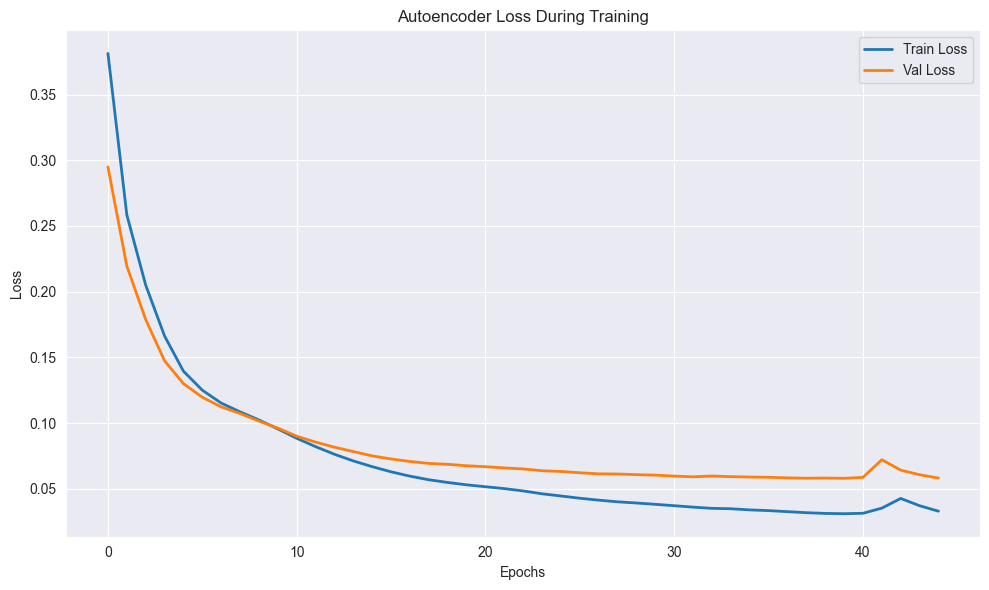

In [27]:
plt.figure(figsize=(10, 6))

# Plotting the loss during training and validation
plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', color='#ff7f0e', linewidth=2)
plt.title('Autoencoder Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Autoencoded skeleton data

In [28]:
X_train_encoded = encoder.predict(X_train_skeleton)
X_train_encoded = X_train_encoded.reshape(-1, 1, code_size)

X_val_encoded = encoder.predict(X_val_skeleton)
X_val_encoded = X_val_encoded.reshape(-1, 1, code_size)

X_test_encoded = encoder.predict(X_test_skeleton)
X_test_encoded = X_test_encoded.reshape(-1, 1, code_size)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


## GRU model which will be trained on both raw and autoencoded skeleton data


In [29]:
# GRU model with enhanced parameters and Dropout
def build_gru_model(input_shape, num_classes):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.GRU(192, return_sequences=True, kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.GRU(128, return_sequences=True, kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.GRU(64, return_sequences=False, kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [30]:
# Creates encoded dataset with skeleton data only
train_dataset_encoded = create_sequence_dataset(
    X_train_encoded,
    y_train,
    batch_size=batch_size,
    shuffle=True,
    cache_file='train_cache1'
)

val_dataset_encoded = create_sequence_dataset(
    X_val_encoded,
    y_val,
    batch_size=batch_size,
    shuffle=True,
    cache_file='val_cache1'
)

test_dataset_encoded = create_sequence_dataset(
    X_test_encoded,
    y_test,
    batch_size=batch_size,
    shuffle=True,
    cache_file='test_cache1'
)

train_steps = int(np.ceil(len(X_train_encoded) / batch_size))
val_steps = int(np.ceil(len(X_val_encoded) / batch_size))
test_steps = int(np.ceil(len(X_test_encoded) / batch_size))

print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")


Created dataset from tensor slices
Shuffled dataset
Cached dataset
Repeated dataset
Batched dataset
Prefetched dataset
Created dataset from tensor slices
Shuffled dataset
Cached dataset
Repeated dataset
Batched dataset
Prefetched dataset
Created dataset from tensor slices
Shuffled dataset
Cached dataset
Repeated dataset
Batched dataset
Prefetched dataset
Training steps per epoch: 32
Validation steps per epoch: 7


In [31]:
input_shape = (1, code_size)  # (time_steps, features)
num_classes = 6

# Training and Evaluation of GRU model
### Encoded skeleton data

In [32]:
gru_model = build_gru_model(input_shape, num_classes) # Model initialization
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
gru_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

start_time = time.time()
epoch_times = []

class TimeCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start
        epoch_times.append(epoch_time)

time_callback = TimeCallback()

history = gru_model.fit(
    train_dataset_encoded,
    epochs=60,
    steps_per_epoch=train_steps,
    batch_size=32,
    validation_data=val_dataset_encoded,
    validation_steps=val_steps,
    callbacks=[early_stopping, time_callback]
)

total_time = time.time() - start_time
avg_epoch_time = sum(epoch_times) / len(epoch_times)

val_loss, val_accuracy = gru_model.evaluate(val_dataset_encoded, steps=val_steps)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Average Time per Epoch: {avg_epoch_time:.2f} seconds")

cpu_usage = psutil.cpu_percent(interval=1)
memory_info = psutil.virtual_memory()

print(f"\nSystem Performance Metrics:")
print(f"CPU Usage: {cpu_usage}%")
print(f"Memory Usage: {memory_info.percent}%")


Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1660 - loss: 4.3991 - val_accuracy: 0.2679 - val_loss: 3.1906
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2400 - loss: 3.8076 - val_accuracy: 0.4107 - val_loss: 3.0714
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2964 - loss: 3.4803 - val_accuracy: 0.5268 - val_loss: 2.9372
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3332 - loss: 3.2773 - val_accuracy: 0.5357 - val_loss: 2.7712
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3506 - loss: 3.0539 - val_accuracy: 0.5893 - val_loss: 2.5960
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4239 - loss: 2.8939 - val_accuracy: 0.6205 - val_loss: 2.4331
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4233 - loss: 2.8359 - val_accuracy: 0.6696 - val_loss: 2.2847
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5373 - loss: 2.5911 - val_accuracy: 0.7143 - val_loss

In [33]:
test_loss, test_accuracy = gru_model.evaluate(X_test_encoded, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8809 - loss: 1.6079  

Test Loss: 1.7853
Test Accuracy: 0.8519


In [34]:
gru_model.save_weights('gru_model.weights.h5')
print("Model weights saved.")

Model weights saved.


### Plot train and val loss and accuracy

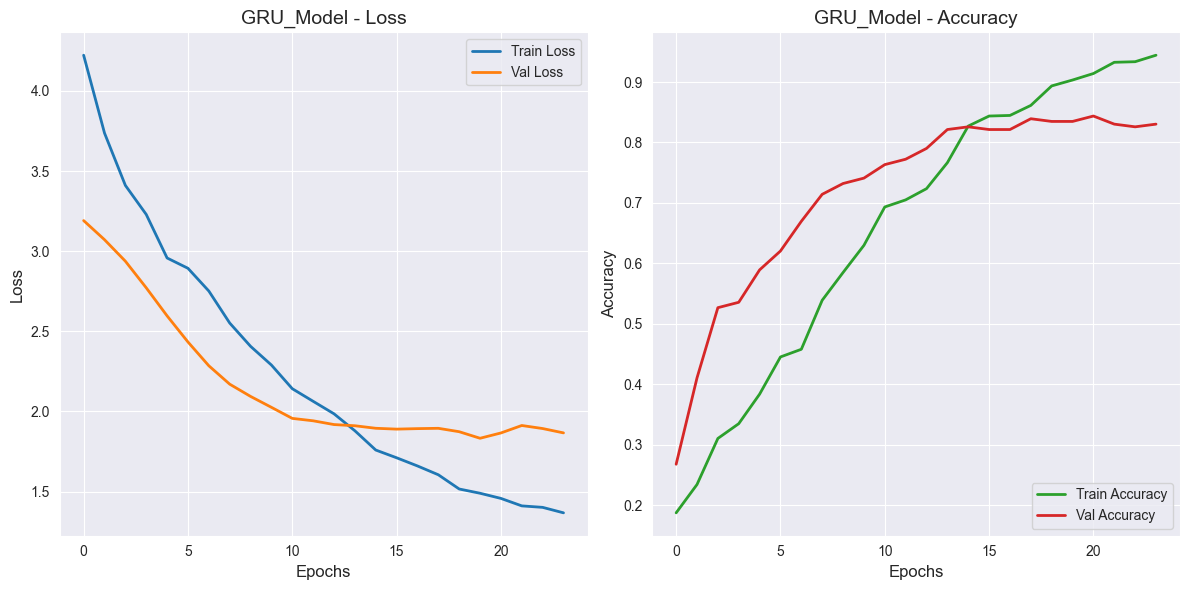

In [35]:
# Plots
model_name = "GRU_Model"

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', color='#ff7f0e', linewidth=2)
plt.title(f'{model_name} - Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#2ca02c', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='#d62728', linewidth=2)
plt.title(f'{model_name} - Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [36]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

y_true = np.argmax(y_test, axis=-1)

y_pred = gru_model.predict(X_test_encoded, verbose=0)
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true, y_pred, output_dict=True)

df_report = pd.DataFrame(report).transpose()
df_report.to_csv('gru.csv', index=True)

print(df_report)


              precision    recall  f1-score     support
0              0.710526  0.750000  0.729730   36.000000
1              0.882353  0.833333  0.857143   36.000000
2              0.871795  0.944444  0.906667   36.000000
3              0.794872  0.861111  0.826667   36.000000
4              0.970588  0.916667  0.942857   36.000000
5              0.906250  0.805556  0.852941   36.000000
accuracy       0.851852  0.851852  0.851852    0.851852
macro avg      0.856064  0.851852  0.852667  216.000000
weighted avg   0.856064  0.851852  0.852667  216.000000


# K-Fold Cross Validation
### For GRU model

In [37]:
X_full_encoded = encoder.predict(skeelton_data_padded)
input_shape = (1, code_size)
X_full_encoded.shape

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(1440, 512)

In [38]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=123)

val_accuracies = []
val_losses = []

# K-fold cross-validation
fold = 1
for train_index, val_index in kf.split(X_full_encoded, gait_labels_one_hot):
    print(f"\nTraining Fold {fold}/{k}")
    X_train_fold, X_val_fold = X_full_encoded[train_index], X_full_encoded[val_index]
    y_train_fold, y_val_fold = gait_labels_one_hot[train_index], gait_labels_one_hot[val_index]

    X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], 1, X_train_fold.shape[-1])
    X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], 1, X_val_fold.shape[-1])

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold)).batch(32).prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold)).batch(32).prefetch(tf.data.AUTOTUNE)

    gru_model_fold = build_gru_model(input_shape, num_classes)

    gru_model_fold.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    history = gru_model_fold.fit(
        train_dataset,
        epochs=50,
        validation_data=val_dataset,
        callbacks=[early_stopping]
    )

    val_loss, val_accuracy = gru_model_fold.evaluate(val_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Fold {fold} - Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    fold += 1

print(f"Average Validation Accuracy: {np.mean(val_accuracies):.4f}")


Training Fold 1/5
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1778 - loss: 4.4881 - val_accuracy: 0.1667 - val_loss: 3.1733
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2187 - loss: 4.0180 - val_accuracy: 0.2500 - val_loss: 3.0571
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2314 - loss: 3.7348 - val_accuracy: 0.3194 - val_loss: 2.9599
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2478 - loss: 3.5076 - val_accuracy: 0.3472 - val_loss: 2.8478
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2828 - loss: 3.3415 - val_accuracy: 0.4097 - val_loss: 2.7291
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2953 - loss: 3.2355 - val_accuracy: 0.4201 - val_loss: 2.6289
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3613 - loss: 3.0365 - val_accuracy: 0.4688 - val_loss: 2.5260
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4334 - loss: 2.7783 - val_accuracy

# GRU + CNN for foot pressure data

In [39]:
def build_model_with_pressure(input_shape_skeleton, input_shape_pressure, num_classes):
    skeleton_input = layers.Input(shape=input_shape_skeleton)
    pressure_input = layers.Input(shape=input_shape_pressure)

    # Skeleton branch with GRU layers
    x_skeleton = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(skeleton_input)
    x_skeleton = layers.BatchNormalization()(x_skeleton)
    x_skeleton = layers.GRU(192, return_sequences=True, kernel_regularizer=regularizers.l2(1e-3))(x_skeleton)
    x_skeleton = layers.BatchNormalization()(x_skeleton)
    x_skeleton = layers.Dropout(0.4)(x_skeleton)
    x_skeleton = layers.GRU(64, return_sequences=True, kernel_regularizer=regularizers.l2(1e-3))(x_skeleton)
    x_skeleton = layers.BatchNormalization()(x_skeleton)
    x_skeleton = layers.Dropout(0.4)(x_skeleton)
    x_skeleton = layers.GRU(64, kernel_regularizer=regularizers.l2(1e-3))(x_skeleton)

    # Pressure branch with Conv1D layers
    x_pressure = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(pressure_input)
    x_pressure = layers.MaxPooling1D(pool_size=2)(x_pressure)
    x_pressure = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x_pressure)
    x_pressure = layers.MaxPooling1D(pool_size=2)(x_pressure)
    x_pressure = layers.GlobalAveragePooling1D()(x_pressure)

    # Concatenation of the outputs from both branches
    x = layers.Concatenate()([x_skeleton, x_pressure])
    x = layers.Dense(96, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)

    # Output layer with softmax activation
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model([skeleton_input, pressure_input], outputs)

    return model


### Datasets tranformation for GRU + CNN

In [40]:
train_dataset_encoded = tf.data.Dataset.from_tensor_slices(
    ((X_train_encoded, X_train_pressure), y_train)
).shuffle(buffer_size=len(X_train_encoded)).batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset_encoded = tf.data.Dataset.from_tensor_slices(
    ((X_val_encoded, X_val_pressure), y_val)
).batch(64).prefetch(tf.data.AUTOTUNE)

test_dataset_encoded = tf.data.Dataset.from_tensor_slices(
    ((X_test_encoded, X_test_pressure), y_test)
).batch(64).prefetch(tf.data.AUTOTUNE)

In [41]:
#Training and Evaluation
input_shape = (1, code_size)
input_shape_pressure = (len(X_train_pressure[1]), len(X_train_pressure[1][1]))
gru_model_with_pressure = build_model_with_pressure(input_shape, input_shape_pressure, num_classes) # Initialize model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
gru_model_with_pressure.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

start_time = time.time()
epoch_times = []

class TimeCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start
        epoch_times.append(epoch_time)

time_callback = TimeCallback()

history = gru_model_with_pressure.fit(
    train_dataset_encoded,
    epochs=60,
    steps_per_epoch=train_steps,
    batch_size=64,
    validation_data=val_dataset_encoded,
    validation_steps=val_steps,
    callbacks=[early_stopping, time_callback],
    shuffle=True
)

total_time = time.time() - start_time
avg_epoch_time = sum(epoch_times) / len(epoch_times)

val_loss, val_accuracy = gru_model_with_pressure.evaluate(val_dataset_encoded, steps=val_steps)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Average Time per Epoch: {avg_epoch_time:.2f} seconds")

cpu_usage = psutil.cpu_percent(interval=1)
memory_info = psutil.virtual_memory()

print(f"\nSystem Performance Metrics:")
print(f"CPU Usage: {cpu_usage}%")
print(f"Memory Usage: {memory_info.percent}%")


Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1839 - loss: 3.1277 - val_accuracy: 0.2685 - val_loss: 3.0423
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3038 - loss: 2.9550 - val_accuracy: 0.3750 - val_loss: 2.9267
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3909 - loss: 2.8049 - val_accuracy: 0.5370 - val_loss: 2.7700
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4697 - loss: 2.6028 - val_accuracy: 0.5833 - val_loss: 2.5639
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5632 - loss: 2.3670 - val_accuracy: 0.6528 - val_loss: 2.3293
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6610 - loss: 2.1093 - val_accuracy: 0.6667 - val_loss: 2.0931
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7298 - loss: 1.8927 - val_accuracy: 0.7685 - val_loss: 1.8938
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7970 - loss: 1.6730 - val_accuracy: 0.7917 - val_loss

In [42]:
test_loss, test_accuracy = gru_model_with_pressure.evaluate(test_dataset_encoded, steps=test_steps)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8404 - loss: 1.4514

Test Loss: 1.4609
Test Accuracy: 0.8333


In [43]:
gru_model_with_pressure.save_weights('gru_model_with_pressure.weights.h5')
print("Model weights saved.")

Model weights saved.


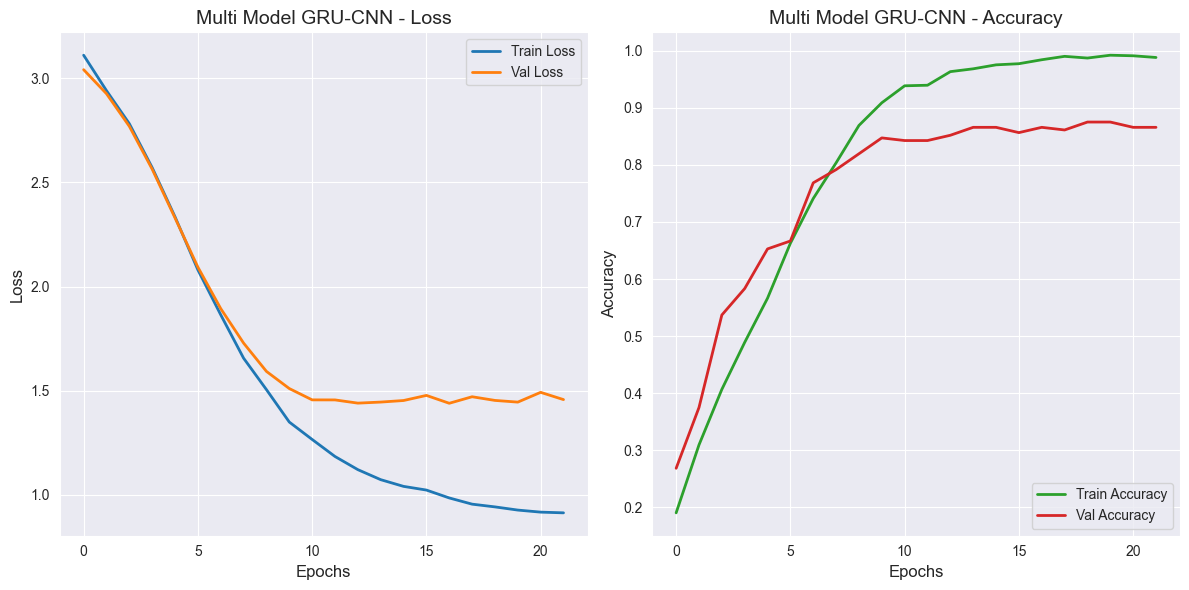

In [44]:
# Plots
model_name = "Multi Model GRU-CNN"

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', color='#ff7f0e', linewidth=2)
plt.title(f'{model_name} - Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#2ca02c', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='#d62728', linewidth=2)
plt.title(f'{model_name} - Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [45]:
y_true = np.argmax(y_test, axis=-1)

# Get model predictions
y_pred = gru_model_with_pressure.predict([X_test_encoded, X_test_pressure], verbose=0)
y_pred = np.argmax(y_pred, axis=-1)

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Save results as CSV
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('model_with_pressure.csv', index=True)

print(df_report)

              precision    recall  f1-score     support
0              0.794872  0.861111  0.826667   36.000000
1              0.843750  0.750000  0.794118   36.000000
2              0.944444  0.944444  0.944444   36.000000
3              0.743590  0.805556  0.773333   36.000000
4              0.891892  0.916667  0.904110   36.000000
5              0.787879  0.722222  0.753623   36.000000
accuracy       0.833333  0.833333  0.833333    0.833333
macro avg      0.834404  0.833333  0.832716  216.000000
weighted avg   0.834404  0.833333  0.832716  216.000000


## K-Fold Cross Validation

In [46]:
avg_val_accuracy = []

for train_index, val_index in kf.split(X_full_encoded):
    X_train_fold, X_val_fold = X_full_encoded[train_index], X_full_encoded[val_index]
    X_train_pressure_fold, X_val_pressure_fold = pressure_data_padded[train_index], pressure_data_padded[val_index]
    y_train_fold, y_val_fold = gait_labels_one_hot[train_index], gait_labels_one_hot[val_index]

    X_train_fold = np.expand_dims(X_train_fold, axis=1)
    X_val_fold = np.expand_dims(X_val_fold, axis=1)

    train_dataset_encoded = tf.data.Dataset.from_tensor_slices(
        ((X_train_fold, X_train_pressure_fold), y_train_fold)
    ).shuffle(buffer_size=len(X_train_fold)).batch(64).prefetch(tf.data.AUTOTUNE)

    val_dataset_encoded = tf.data.Dataset.from_tensor_slices(
        ((X_val_fold, X_val_pressure_fold), y_val_fold)
    ).batch(64).prefetch(tf.data.AUTOTUNE)

    gru_model_with_pressure = build_model_with_pressure(input_shape, input_shape_pressure, num_classes)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    gru_model_with_pressure.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = gru_model_with_pressure.fit(
        train_dataset_encoded,
        epochs=60,
        validation_data=val_dataset_encoded,
        callbacks=[early_stopping],

    )

    val_loss, val_accuracy = gru_model_with_pressure.evaluate(val_dataset_encoded)
    print(f"Fold Validation Loss: {val_loss:.4f}")
    print(f"Fold Validation Accuracy: {val_accuracy:.4f}")

    avg_val_accuracy.append(val_accuracy)

average_accuracy = np.mean(avg_val_accuracy)
print(f"Average Validation Accuracy: {average_accuracy:.4f}")


Epoch 1/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.1869 - loss: 3.1512 - val_accuracy: 0.2535 - val_loss: 3.0259
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2869 - loss: 2.9530 - val_accuracy: 0.4062 - val_loss: 2.8925
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3996 - loss: 2.7647 - val_accuracy: 0.5347 - val_loss: 2.7070
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4906 - loss: 2.5475 - val_accuracy: 0.6181 - val_loss: 2.4635
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5980 - loss: 2.2677 - val_accuracy: 0.7153 - val_loss: 2.2017
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6781 - loss: 2.0190 - val_accuracy: 0.7604 - val_loss: 1.9686
Epoch 7/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7702 - loss: 1.7854 - val_accuracy: 0.8125 - val_loss: 1.7524
Epoch 8/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8518 - loss: 1.5501 - val_accuracy: 0.8194 - v

##LOSO for GRU-CNN

In [47]:
full_dataset_encoded = tf.data.Dataset.from_tensor_slices(
    ((X_full_encoded, pressure_data_padded), gait_labels_one_hot)
).batch(64).prefetch(tf.data.AUTOTUNE)  # No shuffle
subject_ids = dataset['Subject'].values

In [48]:
avg_val_accuracy = []

for subject in np.unique(subject_ids):
    train_index = np.where(subject_ids != subject)[0]
    val_index = np.where(subject_ids == subject)[0]

    X_train_fold, X_val_fold = X_full_encoded[train_index], X_full_encoded[val_index]
    X_train_pressure_fold, X_val_pressure_fold = pressure_data_padded[train_index], pressure_data_padded[val_index]
    y_train_fold, y_val_fold = gait_labels_one_hot[train_index], gait_labels_one_hot[val_index]

    X_train_fold = np.expand_dims(X_train_fold, axis=1)
    X_val_fold = np.expand_dims(X_val_fold, axis=1)

    train_dataset_encoded = tf.data.Dataset.from_tensor_slices(
        ((X_train_fold, X_train_pressure_fold), y_train_fold)
    ).shuffle(buffer_size=len(X_train_fold)).batch(64).prefetch(tf.data.AUTOTUNE)

    val_dataset_encoded = tf.data.Dataset.from_tensor_slices(
        ((X_val_fold, X_val_pressure_fold), y_val_fold)
    ).batch(64).prefetch(tf.data.AUTOTUNE)

    gru_model_with_pressure = build_model_with_pressure(input_shape, input_shape_pressure, num_classes)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    gru_model_with_pressure.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = gru_model_with_pressure.fit(
        train_dataset_encoded,
        epochs=60,
        validation_data=val_dataset_encoded,
        callbacks=[early_stopping]
    )

    val_loss, val_accuracy = gru_model_with_pressure.evaluate(val_dataset_encoded)
    print(f"Fold Validation Loss: {val_loss:.4f}")
    print(f"Fold Validation Accuracy: {val_accuracy:.4f}")

    avg_val_accuracy.append(val_accuracy)

average_accuracy = np.mean(avg_val_accuracy)
print(f"Average Validation Accuracy: {average_accuracy:.4f}")


Epoch 1/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.1666 - loss: 3.1784 - val_accuracy: 0.1167 - val_loss: 3.1378
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2080 - loss: 3.1162 - val_accuracy: 0.1250 - val_loss: 3.1162
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2401 - loss: 3.0540 - val_accuracy: 0.1083 - val_loss: 3.0964
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2808 - loss: 3.0092 - val_accuracy: 0.1667 - val_loss: 3.0790
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3028 - loss: 2.9624 - val_accuracy: 0.1917 - val_loss: 3.0611
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3769 - loss: 2.8988 - val_accuracy: 0.2583 - val_loss: 3.0385
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4069 - loss: 2.8513 - val_accuracy: 0.2667 - val_loss: 3.0157
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4258 - loss: 2.7777 - val_accuracy: 0.2750 - v

# CNN

In [49]:
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # First Convolutional Block
    model.add(Input(shape=input_shape))
    model.add(layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2))

    # Second Convolutional Block
    model.add(layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2))

    # Third Convolutional Block
    model.add(layers.Conv1D(256, kernel_size=5, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2))

    # Flatten and Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.7))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# CNN model on skeleton data

In [50]:
train_dataset = create_sequence_dataset(
    X_train_skeleton,
    y_train,
    batch_size=batch_size,
    shuffle=True,
    cache_file='train_cache2'
)

val_dataset = create_sequence_dataset(
    X_val_skeleton,
    y_val,
    batch_size=batch_size,
    shuffle=False,
    cache_file='val_cache2'
)

test_dataset = create_sequence_dataset(
    X_test_skeleton,
    y_test,
    batch_size=batch_size,
    shuffle=True,
    cache_file='test_cache2'
)

Created dataset from tensor slices
Shuffled dataset
Cached dataset
Repeated dataset
Batched dataset
Prefetched dataset
Created dataset from tensor slices
Cached dataset
Repeated dataset
Batched dataset
Prefetched dataset
Created dataset from tensor slices
Shuffled dataset
Cached dataset
Repeated dataset
Batched dataset
Prefetched dataset


In [51]:
num_classes = 6
cnn_input_shape = (len(skeelton_data_padded[1]), len(skeelton_data_padded[1][1]))

In [52]:
cnn_model = build_cnn_model(cnn_input_shape, num_classes)
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

start_time = time.time()

history = cnn_model.fit(train_dataset,
                        steps_per_epoch=train_steps,
                        epochs=50,
                        batch_size=64,
                        validation_data=val_dataset,
                        validation_steps=val_steps,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)])

total_time = time.time() - start_time
avg_epoch_time = total_time / 30

val_loss, val_accuracy = cnn_model.evaluate(val_dataset, steps=val_steps)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Average Time per Epoch: {avg_epoch_time:.2f} seconds")

cpu_usage = psutil.cpu_percent(interval=1)
memory_info = psutil.virtual_memory()

print(f"\nCPU Usage: {cpu_usage}%")
print(f"Memory Usage: {memory_info.percent}%")


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2856 - loss: 1.8278 - val_accuracy: 0.4777 - val_loss: 1.4084
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5104 - loss: 1.2779 - val_accuracy: 0.7232 - val_loss: 0.8367
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6634 - loss: 0.8918 - val_accuracy: 0.8304 - val_loss: 0.5561
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.8181 - loss: 0.5470 - val_accuracy: 0.9062 - val_loss: 0.3215
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8730 - loss: 0.3864 - val_accuracy: 0.9062 - val_loss: 0.2938
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9030 - loss: 0.2618 - val_accuracy: 0.9509 - val_loss: 0.1590
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9403 - loss: 0.1711 - val_accuracy: 0.9554 - val_loss: 0.1474
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9572 - loss: 0.1443 - val_accuracy: 0.9688 - v

In [53]:
test_loss, test_accuracy = cnn_model.evaluate(test_dataset, steps=test_steps)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9722 - loss: 0.0555

Test Loss: 0.0671
Test Accuracy: 0.9777


In [54]:
cnn_model.save_weights('cnn_model_sk.weights.h5')
print("Model weights saved.")

Model weights saved.


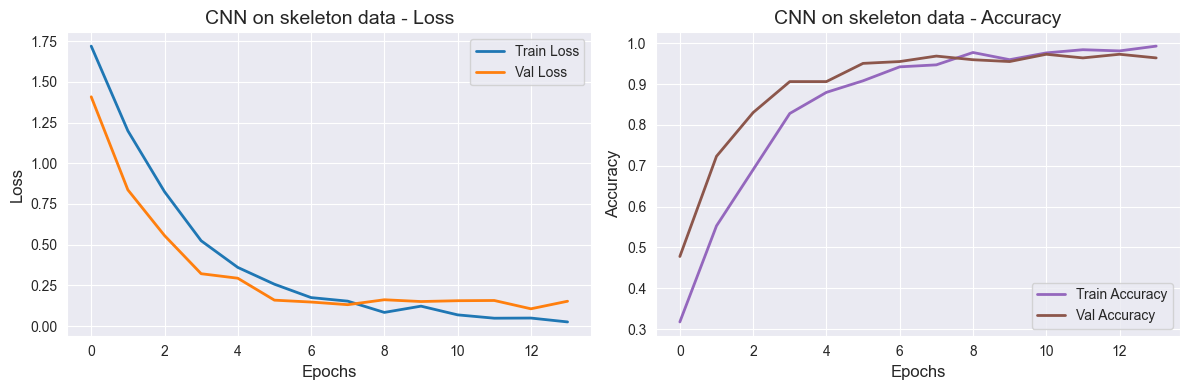

In [55]:
# Plots
model_name = "CNN on skeleton data"

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', color='#ff7f0e', linewidth=2)
plt.title(f'{model_name} - Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#9467bd', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='#8c564b', linewidth=2)

plt.title(f'{model_name} - Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [56]:
y_true = np.argmax(y_test, axis=-1)

y_pred = cnn_model.predict(X_test_skeleton, verbose=0)
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true, y_pred, output_dict=True)

df_report = pd.DataFrame(report).transpose()
df_report.to_csv('cnn_model_sk.csv', index=True)

print(df_report)

              precision    recall  f1-score     support
0              0.972222  0.972222  0.972222   36.000000
1              0.972222  0.972222  0.972222   36.000000
2              0.971429  0.944444  0.957746   36.000000
3              1.000000  0.972222  0.985915   36.000000
4              1.000000  1.000000  1.000000   36.000000
5              0.947368  1.000000  0.972973   36.000000
accuracy       0.976852  0.976852  0.976852    0.976852
macro avg      0.977207  0.976852  0.976847  216.000000
weighted avg   0.977207  0.976852  0.976847  216.000000


# CNN on manually extracted features

#### Creating dataset for skeleton data and joint velocities

In [57]:
train_dataset_cnn = create_sequence_dataset_sk_vel(
    X_train_skeleton,
    X_train_velocities,
    y_train,
    batch_size=batch_size,
    shuffle=True,
    cache_file='train_cache4'
)

val_dataset_cnn = create_sequence_dataset_sk_vel(
    X_val_skeleton,
    X_val_velocities,
    y_val,
    batch_size=batch_size,
    shuffle=False,
    cache_file='val_cache4'
)

test_dataset_cnn = create_sequence_dataset_sk_vel(
    X_test_skeleton,
    X_test_velocities,
    y_test,
    batch_size=batch_size,
    shuffle=True,
    cache_file='test_cache4'
)

train_steps = len(X_train_skeleton) // batch_size
val_steps = len(X_val_skeleton) // batch_size
test_steps = len(X_test_skeleton) // batch_size

Shuffled dataset
Cached dataset
Repeated dataset
Batched dataset
Prefetched dataset
Cached dataset
Repeated dataset
Batched dataset
Prefetched dataset
Shuffled dataset
Cached dataset
Repeated dataset
Batched dataset
Prefetched dataset


In [58]:
input_shape = (len(skeelton_data_padded[1]), len(skeelton_data_padded[1][1]))
num_classes = 6

In [59]:
cnn_model = build_cnn_model(input_shape, num_classes)
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

start_time = time.time()

history = cnn_model.fit(train_dataset_cnn,
                        steps_per_epoch=train_steps,
                        epochs=50,
                        batch_size=64,
                        validation_data=val_dataset_cnn,
                        validation_steps=val_steps,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)])

total_time = time.time() - start_time
avg_epoch_time = total_time / 30

val_loss, val_accuracy = cnn_model.evaluate(val_dataset_cnn, steps=val_steps)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Average Time per Epoch: {avg_epoch_time:.2f} seconds")

cpu_usage = psutil.cpu_percent(interval=1)
memory_info = psutil.virtual_memory()

print(f"\nCPU Usage: {cpu_usage}%")
print(f"Memory Usage: {memory_info.percent}%")


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.2213 - loss: 1.8669 - val_accuracy: 0.4896 - val_loss: 1.5331
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.4211 - loss: 1.4799 - val_accuracy: 0.6823 - val_loss: 1.0234
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6062 - loss: 1.0319 - val_accuracy: 0.8229 - val_loss: 0.6505
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7679 - loss: 0.6702 - val_accuracy: 0.8646 - val_loss: 0.4916
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8240 - loss: 0.4918 - val_accuracy: 0.8698 - val_loss: 0.4321
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8564 - loss: 0.3923 - val_accuracy: 0.9062 - val_loss: 0.2865
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9017 - loss: 0.3029 - val_accuracy: 0.9375 - val_loss: 0.2330
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9396 - loss: 0.1740 - val_accuracy: 0.9323 - v

In [60]:
test_loss, test_accuracy = cnn_model.evaluate(test_dataset_cnn, steps=test_steps)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9563 - loss: 0.1675

Test Loss: 0.1065
Test Accuracy: 0.9688


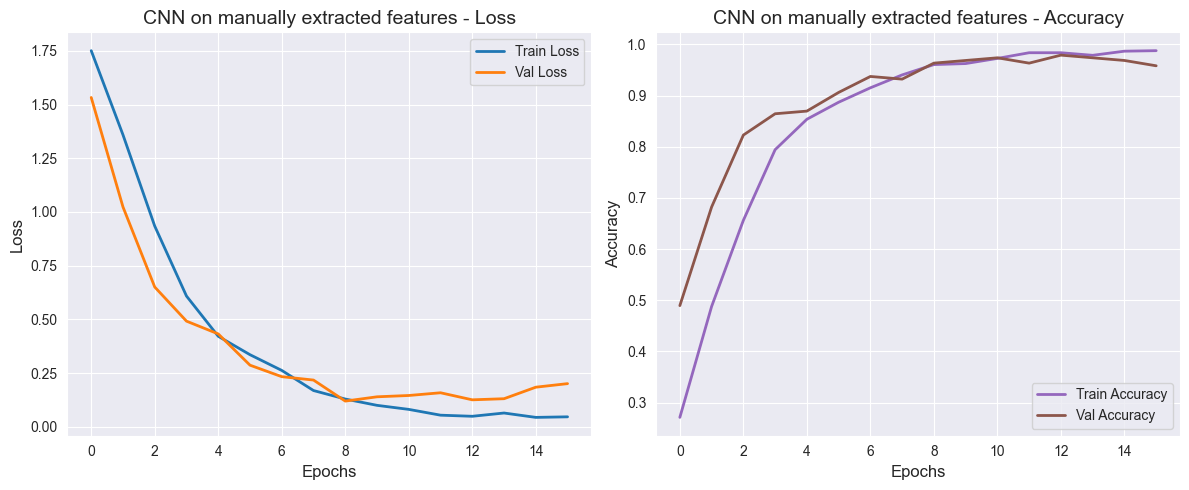

In [61]:
# Plots
model_name = "CNN on manually extracted features"

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', color='#ff7f0e', linewidth=2)
plt.title(f'{model_name} - Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#9467bd', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='#8c564b', linewidth=2)

plt.title(f'{model_name} - Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [62]:
y_true = np.argmax(y_test, axis=-1)

y_pred = cnn_model.predict([X_test_skeleton, X_test_velocities], verbose=0)
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true, y_pred, output_dict=True)

df_report = pd.DataFrame(report).transpose()
df_report.to_csv('cnn_model_sk_vel.csv', index=True)

print(df_report)

              precision    recall  f1-score     support
0              0.944444  0.944444  0.944444   36.000000
1              0.972973  1.000000  0.986301   36.000000
2              1.000000  0.944444  0.971429   36.000000
3              0.971429  0.944444  0.957746   36.000000
4              1.000000  1.000000  1.000000   36.000000
5              0.947368  1.000000  0.972973   36.000000
accuracy       0.972222  0.972222  0.972222    0.972222
macro avg      0.972702  0.972222  0.972149  216.000000
weighted avg   0.972702  0.972222  0.972149  216.000000


## K-fold cross validation

In [63]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
input_shape = (len(skeelton_data_padded[1]), len(skeelton_data_padded[1][1]))

X_skeleton = skeelton_data_padded
X_velocities = joint_velocities_padded
y = gait_labels_one_hot

val_accuracies = []
val_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_skeleton, y), 1):
    print(f"\nTraining Fold {fold}/5")

    X_train_skeleton, X_val_skeleton = X_skeleton[train_idx], X_skeleton[val_idx]
    X_train_vel, X_val_vel = X_velocities[train_idx], X_velocities[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_skeleton, X_train_vel), y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_skeleton, X_val_vel), y_val))

    train_dataset = train_dataset.shuffle(buffer_size=len(X_train_skeleton)).batch(64).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

    cnn_model = build_cnn_model(input_shape, num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = cnn_model.fit(
        train_dataset,
        epochs=60,
        validation_data=val_dataset,
        callbacks=[early_stopping]
    )

    val_loss, val_accuracy = cnn_model.evaluate(val_dataset)
    print(f"Fold {fold} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

avg_val_loss = sum(val_losses) / len(val_losses)
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

print(f"\nAverage Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")



Training Fold 1/5
Epoch 1/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.2074 - loss: 1.8122 - val_accuracy: 0.3611 - val_loss: 1.6237
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.3925 - loss: 1.5649 - val_accuracy: 0.4688 - val_loss: 1.4421
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.4885 - loss: 1.3741 - val_accuracy: 0.5938 - val_loss: 1.2755
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.5596 - loss: 1.2206 - val_accuracy: 0.6146 - val_loss: 1.0977
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.6225 - loss: 1.0533 - val_accuracy: 0.6806 - val_loss: 0.9569
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7134 - loss: 0.8576 - val_accuracy: 0.7431 - val_loss: 0.7748
Epoch 7/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7277 - loss: 0.7386 - val_accuracy: 0.7986 - val_loss: 0.6724
Epoch 8/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.8167 - loss: 0.5919

## LOSO for CNN on manually extracted features

In [64]:
X_skeleton = skeelton_data_padded
X_velocities = joint_velocities_padded
y = gait_labels_one_hot
subject_ids = dataset['Subject'].values

val_accuracies = []
val_losses = []

for subject in np.unique(subject_ids):
    train_idx = np.where(subject_ids != subject)[0]
    val_idx = np.where(subject_ids == subject)[0]

    X_train_skeleton, X_val_skeleton = X_skeleton[train_idx], X_skeleton[val_idx]
    X_train_vel, X_val_vel = X_velocities[train_idx], X_velocities[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_skeleton, X_train_vel), y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_skeleton, X_val_vel), y_val))

    train_dataset = train_dataset.shuffle(buffer_size=len(X_train_skeleton)).batch(64).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

    cnn_model = build_cnn_model(input_shape, num_classes)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = cnn_model.fit(
        train_dataset,
        epochs=60,
        validation_data=val_dataset,
        callbacks=[early_stopping]
    )

    val_loss, val_accuracy = cnn_model.evaluate(val_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)

print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")


Epoch 1/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.2437 - loss: 1.7734 - val_accuracy: 0.1583 - val_loss: 1.8662
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.3812 - loss: 1.5323 - val_accuracy: 0.1250 - val_loss: 1.8627
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.5223 - loss: 1.3049 - val_accuracy: 0.2083 - val_loss: 1.7996
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6316 - loss: 1.0325 - val_accuracy: 0.2083 - val_loss: 1.8178
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.6462 - loss: 0.9277 - val_accuracy: 0.2667 - val_loss: 1.7382
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7441 - loss: 0.7545 - val_accuracy: 0.2500 - val_loss: 1.5854
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7793 - loss: 0.6529 - val_accuracy: 0.2667 - val_loss: 1.7063
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8339 - loss: 0.5223 - val_accuracy: 0.3167 - v

## CNN on full dataset (skeleton based data and foot pressure)

In [70]:
train_dataset_full = create_sequence_dataset_cnn(
    X_train_skeleton,
    X_train_velocities,
    X_train_pressure,
    y_train,
    batch_size=batch_size,
    shuffle=True,
    cache_file='train_cache5'
)

val_dataset_full = create_sequence_dataset_cnn(
    X_val_skeleton,
    X_val_velocities,
    X_val_pressure,
    y_val,
    batch_size=batch_size,
    shuffle=False,
    cache_file='val_cache5'
)

test_dataset_full = create_sequence_dataset_cnn(
    X_test_skeleton,
    X_test_velocities,
    X_test_pressure,
    y_test,
    batch_size=batch_size,
    shuffle=True,
    cache_file='test_cache5'
)

ValueError: Dimensions 1320 and 1008 are not compatible

In [67]:

train_steps = len(X_train_skeleton) // batch_size
val_steps = len(X_val_skeleton) // batch_size
test_steps = len(X_test_skeleton) // batch_size

print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")

ValueError: Dimensions 1320 and 1008 are not compatible

In [69]:
cnn_model = build_cnn_model(cnn_input_shape, num_classes)
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

start_time = time.time()

history = cnn_model.fit(train_dataset_full,
                        steps_per_epoch=train_steps,
                        epochs=50,
                        batch_size=64,
                        validation_data=val_dataset_full,
                        validation_steps=val_steps,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)])

total_time = time.time() - start_time
avg_epoch_time = total_time / 30

val_loss, val_accuracy = cnn_model.evaluate(val_dataset_full, steps=val_steps)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Average Time per Epoch: {avg_epoch_time:.2f} seconds")

cpu_usage = psutil.cpu_percent(interval=1)
memory_info = psutil.virtual_memory()

print(f"\nCPU Usage: {cpu_usage}%")
print(f"Memory Usage: {memory_info.percent}%")


NameError: name 'train_dataset_full' is not defined

In [71]:
test_loss, test_accuracy = cnn_model.evaluate(test_dataset_full, steps=test_steps)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

NameError: name 'test_dataset_full' is not defined

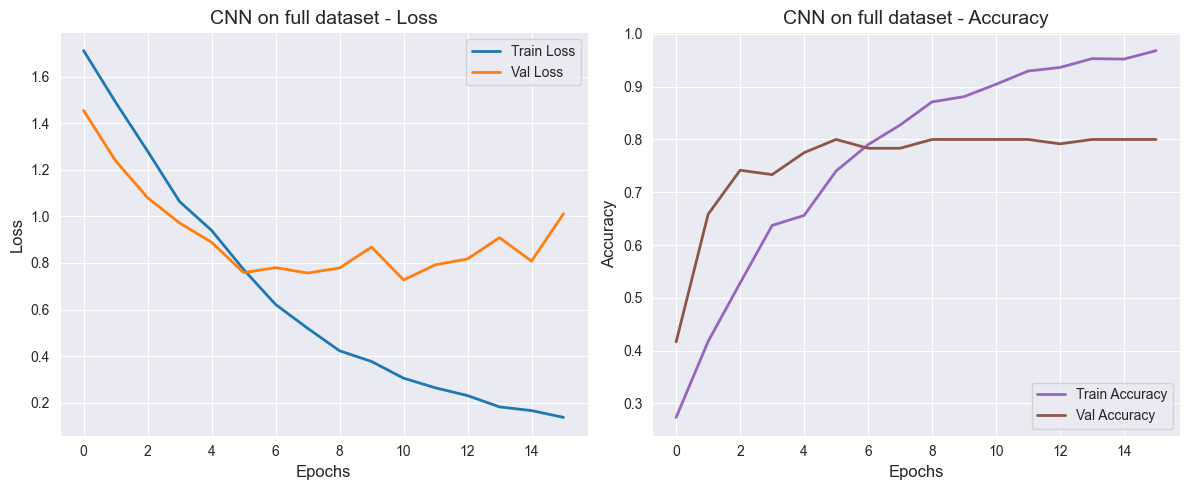

In [72]:
#Plots
# Plots
model_name = "CNN on full dataset"

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', color='#ff7f0e', linewidth=2)
plt.title(f'{model_name} - Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#9467bd', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='#8c564b', linewidth=2)

plt.title(f'{model_name} - Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()



In [73]:
input_shape = (len(skeelton_data_padded[1]), len(skeelton_data_padded[1][1]))  # (time_steps, features)
num_classes = 6
gru_model = build_gru_model(input_shape, num_classes) # Model initialization
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
gru_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

start_time = time.time()
epoch_times = []

class TimeCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start
        epoch_times.append(epoch_time)

time_callback = TimeCallback()

history = gru_model.fit(
    train_dataset,
    epochs=60,
    steps_per_epoch=train_steps,
    batch_size=32,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=[early_stopping, time_callback]
)

total_time = time.time() - start_time
avg_epoch_time = sum(epoch_times) / len(epoch_times)

val_loss, val_accuracy = gru_model.evaluate(val_dataset, steps=val_steps)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Average Time per Epoch: {avg_epoch_time:.2f} seconds")

cpu_usage = psutil.cpu_percent(interval=1)
memory_info = psutil.virtual_memory()

print(f"\nSystem Performance Metrics:")
print(f"CPU Usage: {cpu_usage}%")
print(f"Memory Usage: {memory_info.percent}%")


Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1671 - loss: 4.1345 - val_accuracy: 0.1667 - val_loss: 2.9231
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1609 - loss: 3.9517 - val_accuracy: 0.1667 - val_loss: 2.8867
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1622 - loss: 3.7717 - val_accuracy: 0.1667 - val_loss: 2.8485
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1680 - loss: 3.6754 - val_accuracy: 0.1667 - val_loss: 2.8309
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.1389 - loss: 2.9342 

Validation Loss: 2.9231
Validation Accuracy: 0.1667
Total Training Time: 153.23 seconds
Average Time per Epoch: 38.30 seconds

System Performance Metrics:
CPU Usage: 0.3%
Memory Usage: 64.2%
